In [1]:
import nextbike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import seaborn as sns
import ppscore as pps

In [2]:
dfRaw = nextbike.io.read_file()
dfTrips = nextbike.io.createTrips(dfRaw)
dfTrips = nextbike.io.drop_outliers(dfTrips)
dfTrips.head(2)

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480


In [3]:
dfWeather = nextbike.io.getWeatherData()
dfWeatherMinutes = pd.DataFrame({'date': pd.date_range('2019-01-01', '2020-01-01', freq='min', closed='left')})
dfWeatherMinutes = dfWeatherMinutes.set_index('date')
dfWeatherMinutes = dfWeatherMinutes.join(dfWeather)
dfWeatherMinutes = dfWeatherMinutes.fillna(axis='index', method='ffill')
dfWeatherMinutes

,temperature,precipitation
date,,
2019-01-01 00:00:00,7.6,0.0
2019-01-01 00:01:00,7.6,0.0
2019-01-01 00:02:00,7.6,0.0
2019-01-01 00:03:00,7.6,0.0
2019-01-01 00:04:00,7.6,0.0
...,...,...
2019-12-31 23:55:00,-2.5,0.0
2019-12-31 23:56:00,-2.5,0.0
2019-12-31 23:57:00,-2.5,0.0


In [4]:
dfTrips = dfTrips.join(dfWeatherMinutes, how='left', on='sTime')
dfTrips.head()

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec,temperature,precipitation
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660,-10.7,0.0
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480,-2.2,0.0
3,11169,2019-01-20 15:12:00,2019-01-20 15:27:00,00:15:00,8.759248,50.804725,8.774681,50.822927,True,15,5178.0,5150.0,900,-1.1,0.0
4,11169,2019-01-20 15:39:00,2019-01-20 15:42:00,00:03:00,8.774681,50.822927,8.774681,50.822927,True,15,5150.0,5150.0,180,-1.5,0.0
5,11270,2019-01-20 00:25:00,2019-01-20 00:37:00,00:12:00,8.775948,50.813203,8.775948,50.813203,True,15,5156.0,5156.0,720,-9.7,0.0


In [5]:
dfTrips = dfTrips.drop(columns=['eTime', 'eLong', 'eLat', 'ePlaceNumber','duration'])
dfTrips['sMonth'] = dfTrips['sTime'].dt.month
dfTrips['sDay'] = dfTrips['sTime'].dt.weekday
dfTrips['sHour'] = dfTrips['sTime'].dt.hour
dfTrips['sMinute'] = dfTrips['sTime'].dt.minute


dfTrips.head()

,bNumber,sTime,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute
0,11169,2019-01-20 01:55:00,8.763266,50.795224,True,15,5173.0,660,-10.7,0.0,1,6,1,55
2,11169,2019-01-20 11:58:00,8.770358,50.804522,True,15,5159.0,480,-2.2,0.0,1,6,11,58
3,11169,2019-01-20 15:12:00,8.759248,50.804725,True,15,5178.0,900,-1.1,0.0,1,6,15,12
4,11169,2019-01-20 15:39:00,8.774681,50.822927,True,15,5150.0,180,-1.5,0.0,1,6,15,39
5,11270,2019-01-20 00:25:00,8.775948,50.813203,True,15,5156.0,720,-9.7,0.0,1,6,0,25


In [6]:
dfGroups = dfTrips.resample('h',on='sTime')['durationInSec'].mean().shift(1)
dfGroups


sTime
2019-01-20 00:00:00           NaN
2019-01-20 01:00:00    907.500000
2019-01-20 02:00:00    765.000000
2019-01-20 03:00:00    696.000000
2019-01-20 04:00:00    360.000000
                          ...    
2019-12-31 19:00:00    870.000000
2019-12-31 20:00:00    829.090909
2019-12-31 21:00:00    640.000000
2019-12-31 22:00:00    720.000000
2019-12-31 23:00:00    420.000000
Freq: H, Name: durationInSec, Length: 8304, dtype: float64

In [7]:
allMean = dfTrips['durationInSec'].mean()
dfTrips['autoCorr'] = allMean
for label,content in dfGroups.items():
    dfTrips.loc[dfTrips['sTime'].dt.floor('H') == label,['autoCorr']] = content
dfTrips['autoCorr'].fillna(allMean,inplace=True)

In [8]:
dfTrips['autoCorr'].fillna(allMean,inplace=True)
dfTrips

,bNumber,sTime,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute,autoCorr
0,11169,2019-01-20 01:55:00,8.763266,50.795224,True,15,5173.0,660,-10.7,0.0,1,6,1,55,907.500000
2,11169,2019-01-20 11:58:00,8.770358,50.804522,True,15,5159.0,480,-2.2,0.0,1,6,11,58,951.428571
3,11169,2019-01-20 15:12:00,8.759248,50.804725,True,15,5178.0,900,-1.1,0.0,1,6,15,12,746.086957
4,11169,2019-01-20 15:39:00,8.774681,50.822927,True,15,5150.0,180,-1.5,0.0,1,6,15,39,746.086957
5,11270,2019-01-20 00:25:00,8.775948,50.813203,True,15,5156.0,720,-9.7,0.0,1,6,0,25,891.705505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630964,11265,2019-12-31 18:53:00,8.774454,50.824867,False,15,0.0,900,0.3,0.0,12,1,18,53,507.272727
630965,11265,2019-12-31 22:13:00,8.759248,50.804725,False,15,5178.0,540,-0.8,0.0,12,1,22,13,720.000000
630966,11265,2019-12-31 22:37:00,8.775351,50.808070,False,15,5158.0,420,-1.1,0.0,12,1,22,37,720.000000
630967,11080,2019-12-31 12:26:00,8.774508,50.824840,False,15,0.0,960,2.0,0.0,12,1,12,26,930.000000


In [46]:
corr = np.round(dfTrips.corr(),3)
corr

,bNumber,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute,autoCorr
bNumber,1.000,-0.027,-0.000,0.009,0.595,-0.014,-0.002,0.008,0.002,-0.003,0.007,-0.002,0.003,0.002
sLong,-0.027,1.000,-0.000,-0.009,-0.015,-0.012,-0.001,0.006,0.001,0.009,-0.009,-0.000,0.000,-0.000
sLat,-0.000,-0.000,1.000,0.000,0.000,-0.013,-0.001,0.001,-0.001,0.004,0.002,-0.001,0.002,-0.000
weekend,0.009,-0.009,0.000,1.000,0.003,0.007,0.009,0.035,-0.012,0.056,0.765,-0.007,0.001,0.038
bType,0.595,-0.015,0.000,0.003,1.000,-0.016,0.003,-0.003,-0.001,0.024,0.005,0.001,0.002,-0.008
sPlaceNumber,-0.014,-0.012,-0.013,0.007,-0.016,1.000,0.031,0.007,-0.004,-0.067,0.009,-0.024,-0.002,0.035
durationInSec,-0.002,-0.001,-0.001,0.009,0.003,0.031,1.000,0.149,-0.011,-0.125,0.005,0.024,-0.018,0.197
temperature,0.008,0.006,0.001,0.035,-0.003,0.007,0.149,1.000,-0.038,-0.011,0.011,-0.010,-0.007,0.325
precipitation,0.002,0.001,-0.001,-0.012,-0.001,-0.004,-0.011,-0.038,1.000,0.046,-0.006,0.022,0.016,-0.022
sMonth,-0.003,0.009,0.004,0.056,0.024,-0.067,-0.125,-0.011,0.046,1.000,0.066,0.034,0.020,-0.317


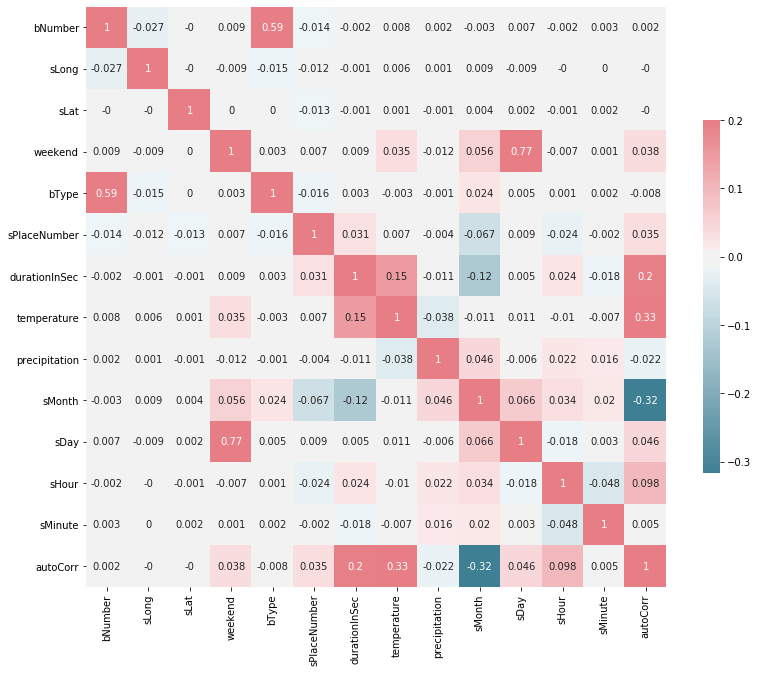

In [52]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(13,13))
sns.heatmap(corr, cmap=cmap, vmax=.2, center=0, annot=True,
            square=True, cbar_kws={"shrink": .5})

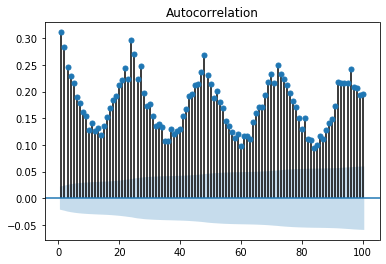

In [43]:
#correlation
plot_acf(dfGroups.fillna(allMean),unbiased=True,zero=False,lags=100)
plt.show()
